## 0. Install & Import

In [ ]:
!pip install konlpy

In [ ]:
!apt-get update -qq # 폰트 설치

In [ ]:
!apt-get install fonts-nanum* -qq # 나눔 폰트 설치

In [ ]:
# 폰트 리스트 확인
import matplotlib.font_manager as fm
sys_font = fm.findSystemFonts()

[f for f in sys_font]

In [ ]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Okt
from PIL import Image
from wordcloud import WordCloud
import PIL
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 2주치 data
it = pd.read_excel("IT과학.xlsx")
economics = pd.read_excel("경제.xlsx")
international = pd.read_excel("국제.xlsx")
culture = pd.read_excel("문화.xlsx")
society = pd.read_excel("사회.xlsx")
sports = pd.read_excel("스포츠.xlsx")
politics = pd.read_excel("정치.xlsx")
region = pd.read_excel("지역.xlsx")

## 1. 특성추출(Spec) 및 키워드 추출 함수

In [ ]:
# word가 숫자인 것 제거하는 함수

def digits_out(cnt_TABLE):

  word_list = cnt_TABLE['word']
  digit_in = []
  for word in word_list:
    tf = any(elem.isdigit() for elem in word)

    if tf == 0:
      tf = bool(1)
    else:
      tf = bool(0)

    digit_in.append(tf)

  return cnt_TABLE[digit_in]

In [ ]:
# 특성 추출 함수

def imp_feature_extract(feature, cnt_col_name):
  ll = feature[0].upper() # 전체 알파벳 소문자화
  for i in range(1,len(feature)):
    ll = ll + ',' + feature[i]

  ll = ll.split(',') # split

  ll = dict(Counter(ll))
  spec = pd.DataFrame(columns=['word', cnt_col_name])
  spec['word'] = ll.keys()
  spec[cnt_col_name] = ll.values()
  spec['word'] = spec['word'].str.upper() # 전부 소문자로 변환
  spec.sort_values(by=cnt_col_name,ascending=False, inplace=True)
  spec = spec.reset_index(drop=True)

  spec = digits_out(spec) # word가 0인 행 제거
  return spec

In [ ]:
# 키워드 추출 함수

def keyword_extract(keyword):
  ll = keyword[0].upper()

  for i in range(1,len(keyword)):
    ll = ll + ',' + keyword[i]

  ll = ll.split(',') # split
  ll = list(map(lambda x: x.upper(), ll))

  ll = dict(Counter(ll))
  kw = pd.DataFrame(columns=['word','word_cnt'])
  kw['word'] = ll.keys()
  kw['word_cnt'] = ll.values()
  kw['word'] = kw['word'].str.upper() # 전부 대문자로 변환
  kw.sort_values(by='word_cnt',ascending=False, inplace=True)
  kw = kw.reset_index(drop=True)

  kw = digits_out(kw) # word가 0인 행 제거

  return kw

## 2. Table merge 함수

In [ ]:
it_s = imp_feature_extract(it['특성추출(가중치순 상위 50개)'], "it_cnt")
economics_s = imp_feature_extract(economics['특성추출(가중치순 상위 50개)'], 'economics_cnt')
international_s = imp_feature_extract(international['특성추출(가중치순 상위 50개)'], 'international_cnt')
culture_s = imp_feature_extract(culture['특성추출(가중치순 상위 50개)'], 'culture_cnt')
society_s = imp_feature_extract(society['특성추출(가중치순 상위 50개)'], 'society_cnt')
sports_s = imp_feature_extract(sports['특성추출(가중치순 상위 50개)'], 'sports_cnt')
politics_s = imp_feature_extract(politics['특성추출(가중치순 상위 50개)'], 'politics_cnt')
region_s = imp_feature_extract(region['특성추출(가중치순 상위 50개)'], 'region_cnt')

In [ ]:
def merge_table(title_list):
  cnt = 0

  for tb in title_list:
    num_upper = 150
    if cnt == 0:
      tb_1 = tb[:num_upper]
      cnt = cnt + 1
    else:
      tb_next = tb[:num_upper]
      tb_1 = pd.merge(tb_1, tb_next, how='left')

  return tb_1

In [ ]:
title = [it_s, economics_s, international_s, society_s, sports_s, politics_s, region_s]
IT = merge_table(title)

title = [economics_s, it_s, international_s, society_s, sports_s, politics_s, region_s]
ECONOMICS = merge_table(title)

title = [international_s, it_s, economics_s, society_s, sports_s]
INTERNATIONAL = merge_table(title)

title = [culture_s, it_s, economics_s, international_s, society_s, sports_s, politics_s, region_s]
CULTURE = merge_table(title)

title = [society_s, international_s, it_s, economics_s, sports_s, politics_s, region_s]
SOCIETY = merge_table(title)

title = [sports_s, it_s, economics_s, international_s, society_s, politics_s, region_s]
SPORTS = merge_table(title)

title = [politics_s, it_s, economics_s, international_s, society_s, sports_s, region_s]
POLITICS = merge_table(title)

title = [region_s, it_s, economics_s, international_s, society_s, sports_s, politics_s]
REGION = merge_table(title)

## 3. custom score function 및 Ranking 함수

In [ ]:
# input : merge만 된 데이터

def Ranking(TABLE, part):

  # 1. Nan 여부에 따른 0 vs 1
  col_list = list(TABLE.columns)[2:]

  for col in col_list:
    TABLE[col] = TABLE[col].apply(lambda x: 1 if x >= 1 else 0)

  # 2. sum
  sum_list = []
  cnt = 0

  for var in col_list:
    if cnt == 0:
      sum_list = TABLE[var]
      cnt = cnt+1
    else:
      sum_list = sum_list + TABLE[var]

  TABLE['sum'] = sum_list

  # 3. minmax sum
  TABLE['minmax_sum'] = (TABLE['sum'] - np.min(TABLE['sum']))/np.max(TABLE['sum'])

  # 4. score
  val = part + "_" + 'cnt'
  TABLE['score'] = np.log1p(TABLE[val])/np.log1p(1+TABLE['minmax_sum'])

  # 5. score 관련 ranking
  TABLE = TABLE.sort_values(by='score',ascending=False).reset_index(drop=True)

  return TABLE

In [ ]:
def ranking_to_wordlist(TABLE, part):
  rank = Ranking(TABLE, part)

  # IT_rank['score'] = IT_rank['score']*100
  # IT_rank['score'] = IT_rank['score'].astype('int')
  # IT_rank['score']

  # 데이터프레임 딕셔너리 형태로 변환
  rank = rank[['word','score']] # 상위 5개 제거
  rank['score'] = np.log1p(rank['score'])
  rank = rank.set_index("word").to_dict()['score']

  return rank

In [ ]:
IT_rank = ranking_to_wordlist(IT, 'it')
ECONOMICS_rank = ranking_to_wordlist(ECONOMICS, 'economics')
INTERNATIONAL_rank = ranking_to_wordlist(INTERNATIONAL, 'international')
# CULTURE_rank = ranking_to_wordlist(CULTURE, 'culture')
SOCIETY_rank = ranking_to_wordlist(SOCIETY, 'society')
SPORTS_rank = ranking_to_wordlist(SPORTS, 'sports')
# POLITICS_rank = ranking_to_wordlist(POLITICS, 'politics')
# REGION_rank = ranking_to_wordlist(REGION, 'region')

In [ ]:
# 데이터프레임 파일로 저장

# r = Ranking(SPORTS, 'sports')
# r.to_excel("/content/drive/MyDrive/P-SAT/23-2/주제분석/sports_list.xlsx",index=False)

## 4. 분야별 워드클라우드 제작

In [ ]:
# 폰트 경로 지정

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

fe = fm.FontEntry(
    fname=f'/usr/share/fonts/truetype/nanum/NanumSquare_acR.ttf',
    name='NanumSquare_acR.ttf') # 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0,fe) # matplotlib에 폰트 추가
plt.rcParams.update({"font.size":18, 'font.family':'NanumSquare_acR.ttf'}) # 폰트 설정

In [ ]:
# 워드클라우드 생성

## ----------------------------------------- 이것만 지정  ----------------------------------------------
IMG_URL = "cloud.png" # 워드클라우드
RANKING = SOCIETY_rank # 워드클라우드 생성하고자 하는 파일 입력
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumSquare_acR.ttf'
## -----------------------------------------------------------------------------------------------------

icon = PIL.Image.open(IMG_URL).convert("RGBA")

img = PIL.Image.new("RGBA",icon.size, (255,255,255))
img.paste(icon, icon)
img=np.array(img)

palette = ['ocean']

wc = WordCloud(random_state = 123, height=400, background_color='white',
               font_path = FONT_PATH, colormap = palette[0], mask=img)
img_wordcloud = wc.generate_from_frequencies(RANKING)
plt.figure(figsize = (10,10)) # 크기 지정
plt.axis('off') # 축 없애기

# def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
#   return ("hsl(300,68%%, %d%%)" % np.random.randint(10,70))

# plt.imshow(img_wordcloud.recolor(color_func=custom_color_func), interpolation='bilinear') # 결과 보여주기

plt.imshow(img_wordcloud) # 결과 보여주기
plt.savefig('sports_워드클라우드') # 저장

## 5. 전체 분야 총합 워드 클라우드

In [ ]:
# outer join 함수

def merge_outer_table(title_list):
  cnt = 0

  for tb in title_list:
    num_upper = 150
    if cnt == 0:
      # tb_1 = tb[:num_upper] # 이거 해제하면 각 분야별 상위 150개만!
      tb_1 = tb
      cnt = cnt + 1
    else:
      # tb_next = tb[:num_upper]
      tb_next = tb
      tb_1 = pd.merge(tb_1, tb_next, how='outer')

  return tb_1

In [ ]:
title = [it_s, economics_s, international_s, society_s, sports_s]
df = merge_outer_table(title) # outer join을 통해 전부 병햡
df = df.fillna(0) # Nan -> 0
df['cnt'] = df['it_cnt'] + df['economics_cnt'] + df['international_cnt'] + df['society_cnt'] + df['sports_cnt'] # 전체 빈도 count
TOTAL_rank = df[['word','cnt']]

# 앞에서는 각 메인 분야의 단어와 다른 분야에서 사용된 단어 빈도를 비교하여서 제시하였다.
# 하지만 전체를 합치는 경우 이러한 방법을 사용해서 scoring할 수가 없게 된다.

TOTAL_rank = TOTAL_rank.sort_values(by='cnt',ascending=False).reset_index(drop=True) # 정렬
TOTAL_rank = TOTAL_rank[5:]
TOTAL_rank['cnt'] = np.log1p(TOTAL_rank['cnt']) # cnt에 로그 씌워줌
TOTAL_rank = TOTAL_rank.set_index("word").to_dict()['cnt'] # 딕셔너리화
# TOTAL_rank

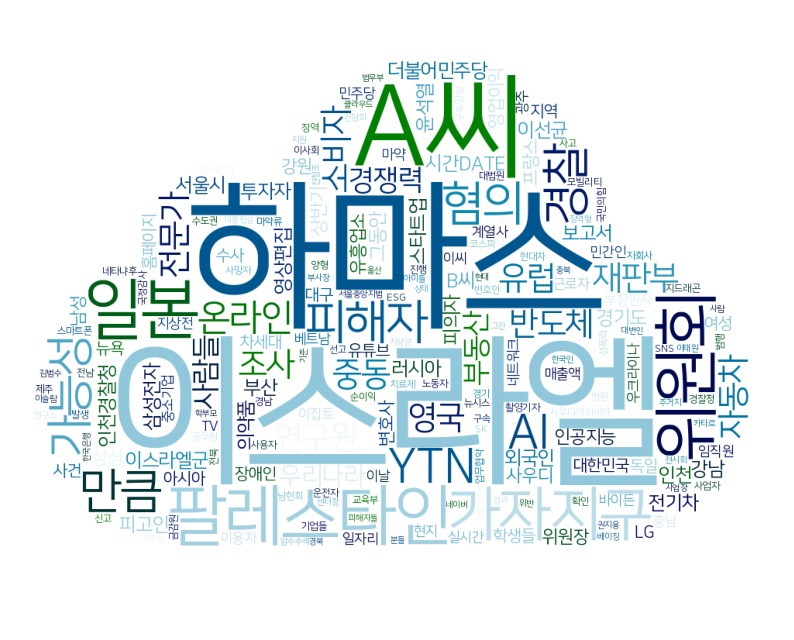

In [ ]:
# 시각화
## ----------------------------------------- 이것만 지정 -----------------------------------------------
IMG_URL = "cloud.png"
RANKING = TOTAL_rank
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumSquare_acR.ttf'
## -----------------------------------------------------------------------------------------------------

icon = PIL.Image.open(IMG_URL).convert("RGBA")

img = PIL.Image.new("RGBA",icon.size, (255,255,255))
img.paste(icon, icon)
img=np.array(img)

palette = ['ocean']
# ocean

wc = WordCloud(random_state = 123, height=400, background_color='white',
               font_path = FONT_PATH, colormap = palette[0], mask=img)
img_wordcloud = wc.generate_from_frequencies(RANKING)
plt.figure(figsize = (10,10)) # 크기 지정
plt.axis('off') # 축 없애기

# def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
#   return ("hsl(300,68%%, %d%%)" % np.random.randint(10,70))

# plt.imshow(img_wordcloud.recolor(color_func=custom_color_func), interpolation='bilinear')

plt.imshow(img_wordcloud) # 결과 보여주기
# plt.savefig('IT_워드클라우드') # 저장